
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [13]:
import numpy as np

In [14]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [15]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [16]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [17]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [18]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # This is the indices where the episode_ends
    episode_ends = tf.placeholder(tf.bool, [None], name='episode_ends')

    # returning the given data to the model
    return states, next_states, actions, episode_ends

In [19]:
# G: Generator/Predictor for generating/predicting the current action and next state
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(state_size + action_size))
        logits_states, logits_actions = tf.split(axis=1, num_or_size_splits=[state_size, action_size], value=logits)
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits_states, logits_actions

In [24]:
# D: Descriminator/Reward function
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing/merging states and actions
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [25]:
def model_loss(states, actions, next_states, episode_ends, # model data 
               action_size, hidden_size, state_size): # model init
    
    # Generator or predictor
    next_states_logits, actions_logits = generator(states=states, state_size=state_size, action_size=action_size, 
                                                   hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    d_logits_fake = discriminator(states=next_states_logits, actions=actions_logits, hidden_size=hidden_size, 
                                  reuse=False)
    actions_real = tf.one_hot(indices=actions, depth=action_size)
    d_logits_real = discriminator(states=next_states, actions=actions_real, hidden_size=hidden_size, 
                                  reuse=True)

    # Attention to episode_ends!!!!!!
    # Where episode ends has to be minimum reward or the logits should be ZERO
    episode_ends = 1 - tf.cast(x=episode_ends, dtype=d_logits_real.dtype)
    d_logits_fake = tf.multiply(x=d_logits_fake, y=episode_ends)
    d_logits_real = tf.multiply(x=d_logits_real, y=episode_ends)
    
    # This for the discriminator and for generator is the opposite
    # Min is 1+0 and max is 1+gamma*Qt+1
    # Assume Rt=1 0-1, 0 for fake and 1 for real
    d_labels_fake = tf.ones_like(d_logits_real) # d_logits_real for minimum is zero ~= 1
    d_labels_real = tf.ones_like(d_logits_real) + (0.99 * d_logits_real) # ~= d_logits_real 
    g_loss_fake = tf.reduce_mean(tf.square(d_logits_fake - d_labels_real)) # ~ Q_fake-Q_real
    g_loss_real = tf.reduce_mean(tf.square(d_logits_real - d_labels_fake)) # ~ Q_fake
    g_loss = g_loss_real + g_loss_fake
    d_loss_fake = tf.reduce_mean(tf.square(d_logits_fake - d_labels_fake)) # ~ = Q-1~=Q ~ Q_fake
    d_loss_real = tf.reduce_mean(tf.square(d_logits_real - d_labels_real)) # ~ = zero=1 ~ 0
    d_loss = d_loss_real + d_loss_fake

    #     # GAN: Adverserial training - G-learning
    #     d_labels_fake = tf.ones_like(d_logits_real) # d_logits_real for minimum is zero ~= 1
    #     #d_labels_real = tf.ones_like(d_logits_real) + (0.99 * d_logits_real) # ~= d_logits_real 
    #     d_labels_real = d_logits_real # ~= d_logits_real 
    #     #     d_labels_fake = tf.zeros_like(d_logits_real)
    #     #     d_labels_real = tf.ones_like(d_logits_real)
    #     g_loss_fake = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_real))
    #     g_loss_real = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_fake))
    #     g_loss = g_loss_real + g_loss_fake

    #     # # GAN: Adverserial training - D-learning
    #     d_loss_fake = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    #     d_loss_real = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    #     d_loss = d_loss_real + d_loss_fake

    # # Rewards fake/real
    # rewards_fake = tf.sigmoid(d_logits_fake)
    # rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, g_loss, d_loss

In [26]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [27]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.episode_ends = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, episode_ends=self.episode_ends) # model input data

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [28]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [29]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [30]:
train_episodes = 1000           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [31]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [32]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [34]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list, d_loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss, d_loss = 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # # Train the model
            # feed_dict = {model.states: states, model.next_states: next_states}
            # rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            # feed_dict={model.states: next_states}
            # next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # # Mean/average fake and real rewards or rewarded generated/given actions
            # rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            # rewards_real_mean = np.mean(rewards_real.reshape(-1))

            # # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            # next_actions_logits[episode_ends] = (0, 0) # NOTE: action size

            # # Bellman equation: Qt = Rt + max(Qt+1)
            # targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions,
                         model.episode_ends: episode_ends}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 6.0 Training g_loss: 1.9311 Training d_loss: 1.8580 Explore P: 0.9994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 37.0 Training g_loss: 0.5470 Training d_loss: 1.0563 Explore P: 0.9958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 20.0 Training g_loss: 0.6369 Training d_loss: 1.0431 Explore P: 0.9938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 21.0 Training g_loss: 0.6323 Training d_loss: 1.0376 Explore P: 0.9917
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 32 Total reward: 30.0 Training g_loss: 10.8582 Training d_loss: 1.0304 Explore P: 0.9398
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 16.0 Training g_loss: 10.2001 Training d_loss: 1.0330 Explore P: 0.9383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 18.0 Training g_loss: 8.9359 Training d_loss: 1.0417 Explore P: 0.9367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 15.0 Training g_loss: 7.9672 Training d_loss: 1.0346 Explore P: 0.9353
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 65 Total reward: 24.0 Training g_loss: 1.1255 Training d_loss: 1.0676 Explore P: 0.8656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 66 Total reward: 14.0 Training g_loss: 1.0709 Training d_loss: 1.0319 Explore P: 0.8644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 52.0 Training g_loss: 1.1064 Training d_loss: 1.0420 Explore P: 0.8600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 33.0 Training g_loss: 1.1115 Training d_loss: 1.0229 Explore P: 0.8572
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 97 Total reward: 38.0 Training g_loss: 1.0183 Training d_loss: 1.0315 Explore P: 0.7913
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 98 Total reward: 20.0 Training g_loss: 1.0166 Training d_loss: 1.0313 Explore P: 0.7897
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 99 Total reward: 30.0 Training g_loss: 1.0237 Training d_loss: 1.0364 Explore P: 0.7874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 73.0 Training g_loss: 1.0977 Training d_loss: 1.0512 Explore P: 0.7817
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 129 Total reward: 20.0 Training g_loss: 1.0928 Training d_loss: 1.0152 Explore P: 0.7233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 130 Total reward: 15.0 Training g_loss: 1.1221 Training d_loss: 1.0102 Explore P: 0.7222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 131 Total reward: 35.0 Training g_loss: 1.0106 Training d_loss: 0.9910 Explore P: 0.7197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 132 Total reward: 68.0 Training g_loss: 1.0723 Training d_loss: 1.0052 Explore P: 0.7149
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 161 Total reward: 84.0 Training g_loss: 1.0045 Training d_loss: 1.0161 Explore P: 0.6451
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 12.0 Training g_loss: 1.0492 Training d_loss: 1.0105 Explore P: 0.6444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 15.0 Training g_loss: 1.1208 Training d_loss: 1.0149 Explore P: 0.6434
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 16.0 Training g_loss: 1.1535 Training d_loss: 1.0250 Explore P: 0.6424
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 193 Total reward: 12.0 Training g_loss: 1.0270 Training d_loss: 1.0006 Explore P: 0.5961
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 194 Total reward: 68.0 Training g_loss: 1.0478 Training d_loss: 1.0003 Explore P: 0.5921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 195 Total reward: 44.0 Training g_loss: 1.0325 Training d_loss: 1.0415 Explore P: 0.5896
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 196 Total reward: 27.0 Training g_loss: 1.0307 Training d_loss: 1.0311 Explore P: 0.5880
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 225 Total reward: 86.0 Training g_loss: 0.9936 Training d_loss: 0.9902 Explore P: 0.5228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 226 Total reward: 18.0 Training g_loss: 1.0383 Training d_loss: 1.0361 Explore P: 0.5219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 227 Total reward: 15.0 Training g_loss: 1.0138 Training d_loss: 1.0106 Explore P: 0.5211
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 228 Total reward: 42.0 Training g_loss: 1.0294 Training d_loss: 1.0259 Explore P: 0.5190
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 257 Total reward: 61.0 Training g_loss: 1.0982 Training d_loss: 1.0202 Explore P: 0.4574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 258 Total reward: 89.0 Training g_loss: 0.8715 Training d_loss: 0.9920 Explore P: 0.4535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 259 Total reward: 37.0 Training g_loss: 1.1064 Training d_loss: 1.0305 Explore P: 0.4518
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 260 Total reward: 47.0 Training g_loss: 0.9688 Training d_loss: 0.9909 Explore P: 0.4497
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 289 Total reward: 44.0 Training g_loss: 1.0412 Training d_loss: 1.0310 Explore P: 0.3920
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 290 Total reward: 94.0 Training g_loss: 1.0322 Training d_loss: 1.0106 Explore P: 0.3885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 291 Total reward: 33.0 Training g_loss: 1.0016 Training d_loss: 1.0005 Explore P: 0.3872
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 292 Total reward: 62.0 Training g_loss: 1.0330 Training d_loss: 1.0207 Explore P: 0.3849
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 321 Total reward: 85.0 Training g_loss: 1.0041 Training d_loss: 1.0057 Explore P: 0.3377
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 322 Total reward: 30.0 Training g_loss: 1.0770 Training d_loss: 1.0001 Explore P: 0.3367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 323 Total reward: 63.0 Training g_loss: 1.0208 Training d_loss: 1.0313 Explore P: 0.3346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 37.0 Training g_loss: 1.0313 Training d_loss: 0.9950 Explore P: 0.3334
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 353 Total reward: 28.0 Training g_loss: 0.6999 Training d_loss: 1.0203 Explore P: 0.3065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 354 Total reward: 18.0 Training g_loss: 0.6626 Training d_loss: 1.0116 Explore P: 0.3059
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 355 Total reward: 17.0 Training g_loss: 0.7417 Training d_loss: 1.0043 Explore P: 0.3054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 356 Total reward: 12.0 Training g_loss: 0.9403 Training d_loss: 1.0272 Explore P: 0.3051
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 385 Total reward: 49.0 Training g_loss: 1.0561 Training d_loss: 1.0051 Explore P: 0.2821
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 386 Total reward: 48.0 Training g_loss: 1.0085 Training d_loss: 1.0057 Explore P: 0.2808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 387 Total reward: 22.0 Training g_loss: 1.0731 Training d_loss: 1.0051 Explore P: 0.2802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 388 Total reward: 34.0 Training g_loss: 1.0143 Training d_loss: 1.0108 Explore P: 0.2793
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 417 Total reward: 84.0 Training g_loss: 0.9951 Training d_loss: 0.9953 Explore P: 0.2401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 33.0 Training g_loss: 1.0248 Training d_loss: 1.0259 Explore P: 0.2393
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 33.0 Training g_loss: 1.0165 Training d_loss: 1.0157 Explore P: 0.2385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 420 Total reward: 32.0 Training g_loss: 1.0146 Training d_loss: 1.0157 Explore P: 0.2378
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 449 Total reward: 71.0 Training g_loss: 1.0199 Training d_loss: 1.0209 Explore P: 0.2058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 450 Total reward: 41.0 Training g_loss: 1.0147 Training d_loss: 1.0261 Explore P: 0.2050
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 451 Total reward: 46.0 Training g_loss: 1.0466 Training d_loss: 1.0155 Explore P: 0.2041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 452 Total reward: 67.0 Training g_loss: 1.0379 Training d_loss: 1.0052 Explore P: 0.2028
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 481 Total reward: 17.0 Training g_loss: 1.1053 Training d_loss: 1.0154 Explore P: 0.1759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 482 Total reward: 8.0 Training g_loss: 1.1271 Training d_loss: 1.0308 Explore P: 0.1757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 8.0 Training g_loss: 1.1060 Training d_loss: 1.0412 Explore P: 0.1756
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 58.0 Training g_loss: 1.0699 Training d_loss: 1.0155 Explore P: 0.1746
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 513 Total reward: 34.0 Training g_loss: 1.0531 Training d_loss: 1.0051 Explore P: 0.1571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 514 Total reward: 49.0 Training g_loss: 1.0760 Training d_loss: 1.0257 Explore P: 0.1564
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 515 Total reward: 27.0 Training g_loss: 0.8614 Training d_loss: 1.0129 Explore P: 0.1560
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 516 Total reward: 15.0 Training g_loss: 0.9868 Training d_loss: 1.0025 Explore P: 0.1558
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 546 Total reward: 9.0 Training g_loss: 0.9238 Training d_loss: 1.0389 Explore P: 0.1506
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 547 Total reward: 9.0 Training g_loss: 0.9569 Training d_loss: 1.0172 Explore P: 0.1505
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 548 Total reward: 15.0 Training g_loss: 1.2671 Training d_loss: 1.0245 Explore P: 0.1503
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 549 Total reward: 9.0 Training g_loss: 1.2938 Training d_loss: 1.0094 Explore P: 0.1502
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 578 Total reward: 27.0 Training g_loss: 0.9102 Training d_loss: 1.0077 Explore P: 0.1462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 11.0 Training g_loss: 0.8523 Training d_loss: 0.9975 Explore P: 0.1461
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 9.0 Training g_loss: 0.9286 Training d_loss: 1.0122 Explore P: 0.1459
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 581 Total reward: 9.0 Training g_loss: 1.0031 Training d_loss: 1.0006 Explore P: 0.1458
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 611 Total reward: 9.0 Training g_loss: 1.0949 Training d_loss: 1.0163 Explore P: 0.1339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 612 Total reward: 78.0 Training g_loss: 1.0751 Training d_loss: 1.0159 Explore P: 0.1329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 613 Total reward: 85.0 Training g_loss: 1.0850 Training d_loss: 1.0054 Explore P: 0.1319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 614 Total reward: 54.0 Training g_loss: 1.1996 Training d_loss: 0.9993 Explore P: 0.1312
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 643 Total reward: 37.0 Training g_loss: 0.9557 Training d_loss: 0.9959 Explore P: 0.1153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 644 Total reward: 88.0 Training g_loss: 0.9648 Training d_loss: 1.0009 Explore P: 0.1143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 645 Total reward: 33.0 Training g_loss: 0.9961 Training d_loss: 1.0057 Explore P: 0.1140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 646 Total reward: 59.0 Training g_loss: 1.0137 Training d_loss: 1.0211 Explore P: 0.1134
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 675 Total reward: 28.0 Training g_loss: 0.9999 Training d_loss: 0.9902 Explore P: 0.0992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 676 Total reward: 107.0 Training g_loss: 1.0265 Training d_loss: 1.0054 Explore P: 0.0983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 677 Total reward: 34.0 Training g_loss: 1.0449 Training d_loss: 1.0258 Explore P: 0.0980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 678 Total reward: 69.0 Training g_loss: 1.0218 Training d_loss: 1.0106 Explore P: 0.0974
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 708 Total reward: 8.0 Training g_loss: 1.1981 Training d_loss: 1.0098 Explore P: 0.0911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 709 Total reward: 8.0 Training g_loss: 1.2947 Training d_loss: 1.0094 Explore P: 0.0910
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 710 Total reward: 7.0 Training g_loss: 1.3870 Training d_loss: 1.0030 Explore P: 0.0910
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 711 Total reward: 10.0 Training g_loss: 1.4256 Training d_loss: 0.9977 Explore P: 0.0909
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 741 Total reward: 11.0 Training g_loss: 1.0559 Training d_loss: 1.0052 Explore P: 0.0885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 742 Total reward: 7.0 Training g_loss: 1.0850 Training d_loss: 1.0101 Explore P: 0.0885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 743 Total reward: 13.0 Training g_loss: 1.1375 Training d_loss: 1.0097 Explore P: 0.0884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 744 Total reward: 11.0 Training g_loss: 1.1321 Training d_loss: 1.0151 Explore P: 0.0883
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 775 Total reward: 8.0 Training g_loss: 1.0436 Training d_loss: 1.0053 Explore P: 0.0862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 776 Total reward: 8.0 Training g_loss: 1.0794 Training d_loss: 1.0256 Explore P: 0.0861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 777 Total reward: 9.0 Training g_loss: 1.0728 Training d_loss: 1.0205 Explore P: 0.0861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 778 Total reward: 9.0 Training g_loss: 1.0585 Training d_loss: 1.0104 Explore P: 0.0860
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 807 Total reward: 9.0 Training g_loss: 1.0877 Training d_loss: 0.9999 Explore P: 0.0841
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 808 Total reward: 8.0 Training g_loss: 1.0975 Training d_loss: 1.0101 Explore P: 0.0841
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 809 Total reward: 9.0 Training g_loss: 1.0975 Training d_loss: 1.0101 Explore P: 0.0840
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 810 Total reward: 12.0 Training g_loss: 1.0392 Training d_loss: 0.9951 Explore P: 0.0839
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 840 Total reward: 8.0 Training g_loss: 1.0546 Training d_loss: 1.0206 Explore P: 0.0819
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 841 Total reward: 8.0 Training g_loss: 1.0638 Training d_loss: 1.0154 Explore P: 0.0819
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 842 Total reward: 8.0 Training g_loss: 1.0596 Training d_loss: 0.9950 Explore P: 0.0818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 843 Total reward: 9.0 Training g_loss: 1.1024 Training d_loss: 1.0254 Explore P: 0.0818
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 874 Total reward: 9.0 Training g_loss: 1.0121 Training d_loss: 1.0107 Explore P: 0.0798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 875 Total reward: 9.0 Training g_loss: 1.0629 Training d_loss: 1.0411 Explore P: 0.0797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 876 Total reward: 10.0 Training g_loss: 1.0311 Training d_loss: 1.0003 Explore P: 0.0797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 877 Total reward: 10.0 Training g_loss: 1.0455 Training d_loss: 1.0156 Explore P: 0.0796
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 907 Total reward: 10.0 Training g_loss: 1.0370 Training d_loss: 1.0053 Explore P: 0.0778
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 908 Total reward: 10.0 Training g_loss: 1.0663 Training d_loss: 1.0153 Explore P: 0.0777
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 909 Total reward: 8.0 Training g_loss: 1.0565 Training d_loss: 1.0051 Explore P: 0.0777
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 910 Total reward: 7.0 Training g_loss: 1.0565 Training d_loss: 1.0103 Explore P: 0.0776
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 939 Total reward: 9.0 Training g_loss: 1.0091 Training d_loss: 1.0159 Explore P: 0.0760
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 940 Total reward: 8.0 Training g_loss: 0.9853 Training d_loss: 1.0059 Explore P: 0.0759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 941 Total reward: 8.0 Training g_loss: 0.9932 Training d_loss: 1.0212 Explore P: 0.0759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 942 Total reward: 8.0 Training g_loss: 0.9903 Training d_loss: 1.0264 Explore P: 0.0758
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 971 Total reward: 9.0 Training g_loss: 1.0655 Training d_loss: 1.0310 Explore P: 0.0742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 972 Total reward: 9.0 Training g_loss: 1.0352 Training d_loss: 1.0157 Explore P: 0.0742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 973 Total reward: 11.0 Training g_loss: 1.0309 Training d_loss: 1.0208 Explore P: 0.0741
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 8.0 Training g_loss: 1.0149 Training d_loss: 1.0158 Explore P: 0.0740
---------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

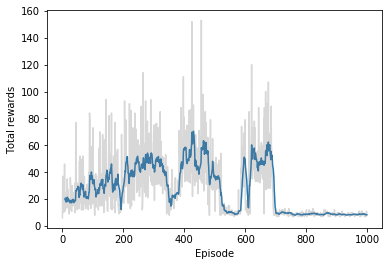

In [36]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

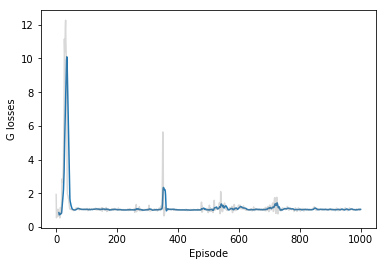

In [37]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

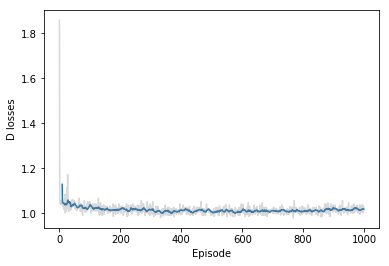

In [38]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.